In [1]:
%pylab inline
import pandas as pd
from dateparser import parse
from tqdm import tqdm

from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


# Purpose:
Predict future changes in features given changes of features in the past.

In [2]:
features = ['Country Code',
            'Custom_Time_Code',
            'SP.DYN.IMRT.IN',
            'SP.ADO.TFRT',
            'VC.IHR.PSRC.P5',
            'SI.POV.GINI',
            'NY.GDP.PCAP.CD',
            'SE.PRM.TENR',
            'SE.PRM.TENR.FE',
            'SE.PRM.TENR.MA',
            'EN.ATM.GHGT.KT.CE',
            'EG.USE.ELEC.KH.PC',
            'EG.ELC.ACCS.ZS']

df = pd.read_csv('cleaned.csv', parse_dates=['Custom_Time_Code'])[features]


grouped = df.groupby('Country Code')

drop = set()
for col in tqdm(df.columns):
    counted = grouped[col].count()
    for country in counted.index[counted < 3]:
        drop.add(country)
        
drop.add('USA')

df = df[df['Country Code'].apply(lambda x: x not in drop)]

100%|██████████| 13/13 [00:00<00:00, 1567.96it/s]


In [3]:
def s_chg(s):
    s = s.values
    return s[-1]-s[0]

def df_chg(df):
    new = []
    for c in df.columns:
        new.append(s_chg(df[c]))
    new = pd.Series(new)
    new.index = ['DELTA_' + c for c in df.columns]
    return new

In [16]:
'''
Grab all rows from df where Custom_Time_Code < 2010.
'''

col_to_predict = 'SI.POV.GINI'

past = df[df['Custom_Time_Code'] < parse('Jan 1st, 2010')]

present = df[df['Custom_Time_Code'] > parse('Jan 1st, 1999')]


changes = past.groupby('Country Code').apply(df_chg)

present_changes = present.groupby('Country Code').apply(df_chg)


yr_2000 = df[df['Custom_Time_Code'].between(parse('Jan 1st, 1995'), parse('Jan 1st, 2010'))].set_index('Country Code')
yr_2000['country'] = yr_2000.index


yr_2010 = df[df['Custom_Time_Code'] > parse('Jan 1st, 2010')].set_index('Country Code')
yr_2010['country'] = yr_2000.index

X = pd.concat([yr_2000, changes], axis=1).drop(['Custom_Time_Code','country','DELTA_Custom_Time_Code'], axis=1)

X_for_extrapolation = pd.concat([yr_2010, present_changes], axis=1).drop(['Custom_Time_Code','country','DELTA_Custom_Time_Code'], axis=1)



y = df[df['Custom_Time_Code'] > parse('Jan 1st, 2009')].set_index('Country Code')[col_to_predict]

reg = LinearRegression().fit(X, y)

In [17]:
reg.score(X, y)

0.8959075461162058

In [18]:
(((reg.predict(X) - y)**2)**.5).mean()

2.0411062248063234

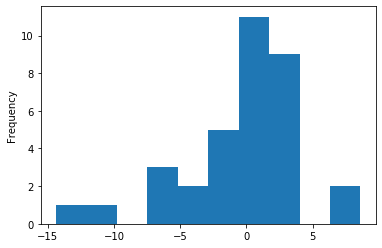

In [19]:
changes["DELTA_"+col_to_predict].plot(kind='hist')

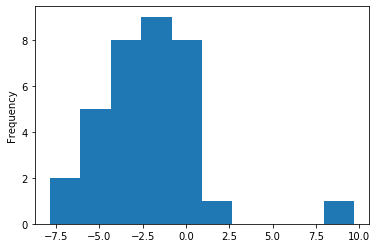

In [15]:
(reg.predict(X_for_extrapolation) - y).plot(kind='hist')